In [1]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
import random
random.seed(0)
ITER_COUNT = 1000

In [2]:
def split_feature_and_target(df):
    df = df.copy()
    headers = df.columns
    df_target = df.pop(headers[0])
    df_feature = df.copy()
    return df_feature, df_target

In [3]:
def standardize_sr(sr, avg, std):
    sr_standardized = sr.apply(lambda x: ((x - avg) / std))
    return sr_standardized

In [4]:
def standardize(df):
    df = df.copy()
    df_std = df.apply(lambda x: standardize_sr(x, x.mean(), x.std()))
    return pd.DataFrame(df_std)

In [5]:
def covariance(df):
    df_covar_mat = pd.DataFrame(np.dot(df.T, df))
    df_covar_mat /= len(df) - 1
    return np.linalg.eig(df_covar_mat)

In [6]:
def pca(data, e_val, e_vec, dimension):
    e_val = e_val.copy()
    e_vec = e_vec.copy()
    indices_l = []
    vectors_l = []
    for i in range(dimension):
        index = e_val.idxmax(axis = 0)[0]
        indices_l.append(index)
        e_val.loc[index] = -math.inf
    for x in indices_l:
        vectors_l.append(e_vec[x].to_numpy())
    df = pd.DataFrame(vectors_l).T
    return np.dot(data, np.transpose(vectors_l))

In [7]:
def get_random_number_list(count, lower_lim, upper_lim):
    return [round(random.uniform(lower_lim, upper_lim), 2) for _ in range(count)]

In [9]:
def update_refs(c):
    new_refs = []
    for cluster in c:
        new_refs.append(np.mean(cluster, axis=0))
    return new_refs

In [10]:
def calculate_purity(targets):
    pos_ctr = 0
    ctr = 0
    for target in targets:
        pos_ctr += max(target.count(1.0), target.count(-1.0))
        ctr += len(target)
    return pos_ctr / ctr

In [11]:
def visualize(cluster, target, reference, color, iteration_string):
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(projection = '3d')
    i = 0
    for i in range(len(reference)):
        ax.scatter(reference[i][0], reference[i][1], reference[i][2], s=100, c=color[i], marker='o')
        ax.scatter([row[0] for row in cluster[i]], 
                   [row[1] for row in cluster[i]], 
                   [row[2] for row in cluster[i]], c=color[i], marker='x')
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_title(f"Iteration {iteration_string} Purity = {calculate_purity(target)}")
    plt.show()

In [12]:
def generate_random_number_list(count, lower_lim, upper_lim):
    return [round(random.uniform(lower_lim, upper_lim), 2) for _ in range(count)]

In [13]:
def get_init_refs(feat_count, k):
    colors = ['g','c','b','r','k','y','m']
    result = []
    for _ in range(k):
        random_nums = generate_random_number_list(feat_count, -2, 2)
        result.append(random_nums)
    return np.array(result), colors[:k]

In [14]:
def my_k_means(df_data, target, k):
    num_features = len(df_data.loc[0])
    num_data = len(df_data)
    new_reference, colors = get_init_refs(num_features, k)
    cur_reference = np.array([[9 for _ in range(len(new_reference[0]))] for _ in range(len(new_reference))]) # Large Random matrix
    iter_ctr = 0
    for _ in range(ITER_COUNT):
        # Stopping Condition
        difference_ref = []
        for ctr in range(len(cur_reference)):
            difference_ref.append(np.linalg.norm(new_reference[ctr] - cur_reference[ctr]))
        if abs(np.linalg.norm(difference_ref)) < 2 ** -23:
            break
        # Clustering
        cluster = []
        cluster_target = []
        # Initialize
        for _ in range(k):
            cluster.append([])
            cluster_target.append([])
        for i in range(len(df_data)):
            row = df_data.loc[i].to_numpy()
            difference_values = []
            for vector in new_reference:
                difference_values.append(np.linalg.norm(row - vector))
            min_index = np.argmin(difference_values)
            cluster[min_index].append(row)
            cluster_target[min_index].append(target[i])
        if iter_ctr == 0:
            visualize(cluster, cluster_target, new_reference, colors, "1")
        cur_reference = new_reference
        new_reference = update_refs(cluster)
        iter_ctr += 1
    return cluster, cluster_target, cur_reference, colors, iter_ctr

In [15]:
df_data = pd.read_csv('diabetes.csv', header=None)

In [16]:
df_x, sr_y = split_feature_and_target(df_data)
df_x_std = standardize(df_x)

In [17]:
eig_val, eig_vec = covariance(df_x_std)

In [18]:
three_dim_data = pca(df_x_std, pd.DataFrame(eig_val), pd.DataFrame(eig_vec), 3)
df_three_dim_data = pd.DataFrame(three_dim_data)

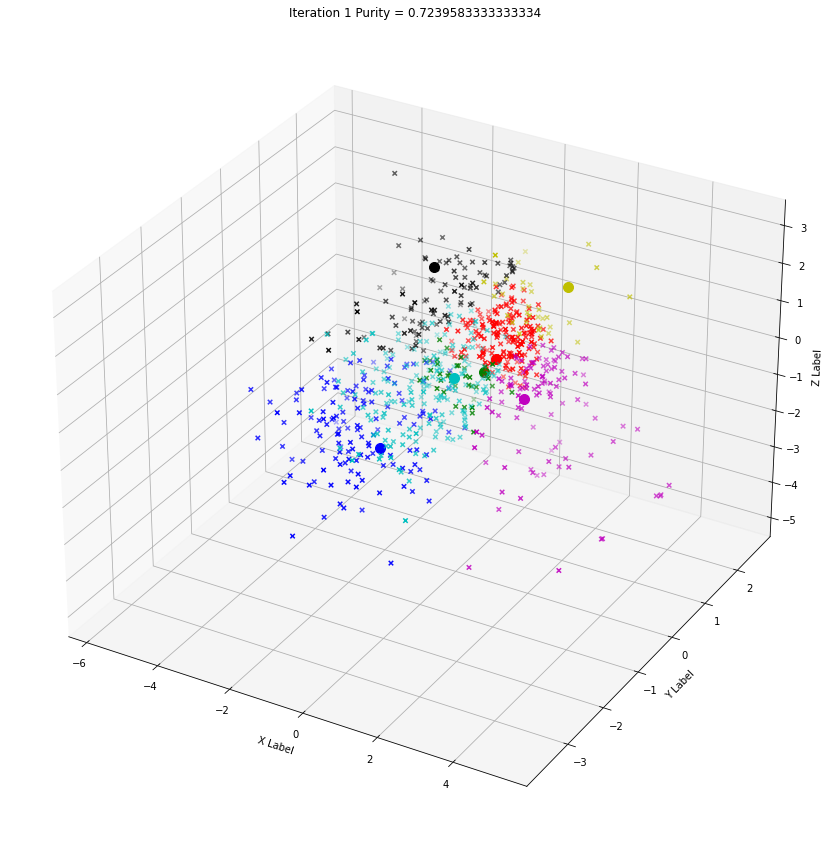

In [25]:
cluster, cluster_tartet, new_reference, colors, iteration_count = my_k_means(df_three_dim_data, sr_y, 7)

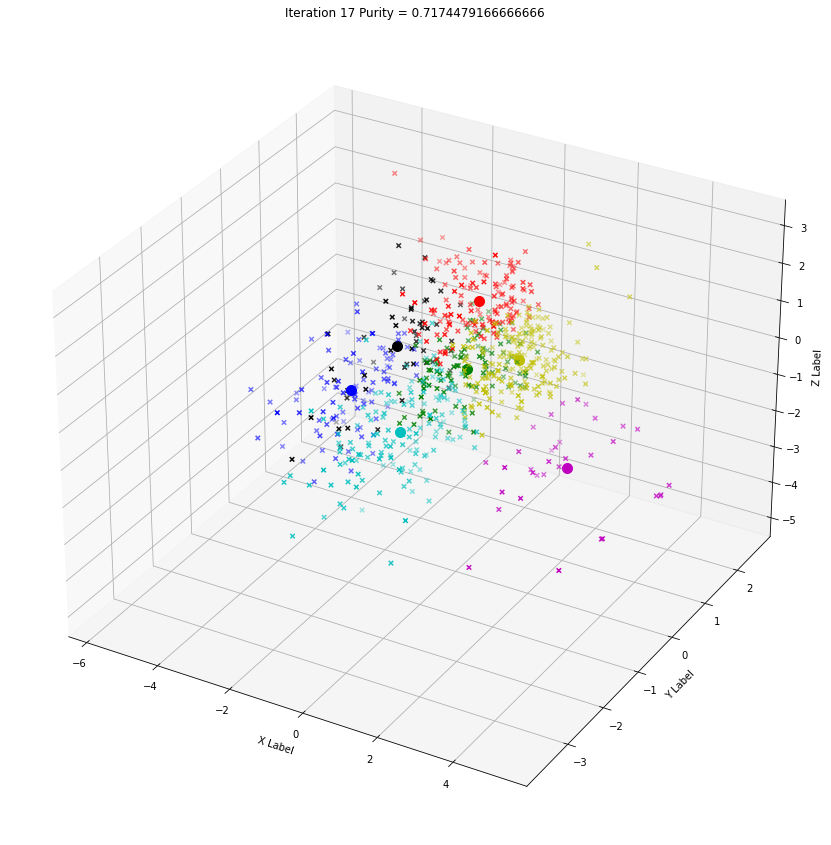

In [26]:
visualize(cluster, cluster_tartet, new_reference, colors, f"{iteration_count + 1}")

In [ ]:
# df_data = df_three_dim_data.copy()
# target = sr_y.copy()
# k = 7

# num_features = len(df_data.loc[0])
# num_data = len(df_data)
# new_reference, colors = get_init_refs(num_features, k)
# cur_reference = np.array([[9 for _ in range(len(new_reference[0]))] for _ in range(len(new_reference))]) # Large Random matrix

# difference_ref = []
# for ctr in range(len(cur_reference)):
#     difference_ref.append(np.linalg.norm(new_reference[ctr] - cur_reference[ctr]))

# cluster = []
# cluster_target = []
# for _ in range(k):
#     cluster.append([])
#     cluster_target.append([])

# for i in range(len(df_data)):
#     row = df_data.loc[i].to_numpy()
#     difference_values = []
#     for vector in new_reference:
#         difference_values.append(np.linalg.norm(row - vector))
#     min_index = np.argmin(difference_values)
#     cluster[min_index].append(row)
#     cluster_target[min_index].append(target[i])

# if iter_ctr == 0:
# #         print(cluster)
# #         print(cluster_target)
# #         print(new_reference)
# #         print(colors)
#     visualize(cluster, cluster_target, new_reference, colors, "1")
# cur_reference = new_reference
# new_reference = update_refs(cluster)

# np.argmin(difference_values)

# new_refs = []
# for c in cluster:
#     new_refs.append(np.mean(c, axis=0))
# new_refs